# 1. 导入库和设置环境

In [21]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV, cross_val_score

# 导入模型
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# 尝试导入XGBoost，如果不可用则跳过
try:
    import xgboost as xgb
    has_xgboost = True
except ImportError:
    print("Warning: XGBoost is not installed. XGBoost model will be skipped.")
    has_xgboost = False

# 尝试导入SHAP，如果不可用则跳过
try:
    import shap
    has_shap = True
except ImportError:
    print("Warning: SHAP is not installed. SHAP analysis will be skipped.")
    has_shap = False

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 设置全局参数
RANDOM_STATE = 42
CV_FOLDS = 5
N_JOBS = -1  # 使用所有可用CPU核心

# 2. 数据加载与检查

In [22]:
# 1. 加载预处理后的数据
print("=== Loading preprocessed data ===")
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
y_test = pd.read_csv('y_test.csv').values.ravel()

# 加载标签编码器以获取类别名称
label_encoder = joblib.load('label_encoder.pkl')
class_names = label_encoder.classes_
print(f"Class names: {class_names}")

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Feature names: {X_train.columns.tolist()}")

# 检查类别分布
print("\nTarget distribution in training data:")
train_dist = pd.Series(y_train).value_counts(normalize=True)
print(train_dist)

=== Loading preprocessed data ===
Class names: ['High' 'Low' 'Medium']
Training data shape: (8000, 17)
Testing data shape: (2000, 17)
Feature names: ['age', 'stress_level', 'sleep_hours', 'physical_activity_days', 'depression_score', 'anxiety_score', 'social_support_score', 'mental_health_history', 'seeks_treatment', 'treatment_history_interaction', 'gender_Male', 'gender_Other', 'employment_status_Self-employed', 'employment_status_Student', 'employment_status_Unemployed', 'work_environment_On-site', 'work_environment_Remote']

Target distribution in training data:
2    0.589250
0    0.236875
1    0.173875
dtype: float64


# 3. 模型评估函数

In [23]:
def evaluate_model(model, X_train, X_test, y_train, y_test, class_names):
    """评估模型性能并返回结果"""
    # 训练时间
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # 预测
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # 计算评估指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # 对"High"风险类别的特定评估
    high_idx = np.where(class_names == 'High')[0][0]
    high_precision = precision_score(y_test, y_pred, labels=[high_idx], average='micro')
    high_recall = recall_score(y_test, y_pred, labels=[high_idx], average='micro')
    high_f1 = f1_score(y_test, y_pred, labels=[high_idx], average='micro')
    
    # 返回结果字典
    return {
        'model': model.__class__.__name__,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'high_precision': high_precision,
        'high_recall': high_recall,
        'high_f1': high_f1,
        'train_time': train_time,
        'predict_time': predict_time,
        'model_object': model,
        'predictions': y_pred
    }

# 4. 混淆矩阵可视化函数

In [24]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """绘制混淆矩阵"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name.replace(" ", "_")}_confusion_matrix.png', dpi=300)
    plt.close()

# 5. 模型创建函数

In [25]:
def create_models():
    """创建要评估的模型列表"""
    models = []
    
    # 逻辑回归（带类别权重）
    models.append(("Logistic Regression", 
                   LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE)))
    
    # 决策树
    models.append(("Decision Tree", 
                   DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)))
    
    # 随机森林
    models.append(("Random Forest", 
                   RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=RANDOM_STATE)))
    
    # 梯度提升树
    models.append(("Gradient Boosting", 
                   GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)))
    
    # XGBoost (如果可用)
    if has_xgboost:
        models.append(("XGBoost", 
                      xgb.XGBClassifier(scale_pos_weight=1, random_state=RANDOM_STATE)))
    
    # 支持向量机
    models.append(("SVM", 
                   SVC(class_weight='balanced', probability=True, random_state=RANDOM_STATE)))
    
    # K最近邻
    models.append(("KNN", 
                   KNeighborsClassifier(n_neighbors=5)))
    
    # 朴素贝叶斯
    models.append(("Naive Bayes", 
                   GaussianNB()))
    
    # 神经网络
    models.append(("Neural Network", 
                   MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=RANDOM_STATE)))
    
    return models

# 6. 模型训练与评估函数

In [26]:
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test, class_names):
    """训练并评估所有模型"""
    results = []
    
    print("\n=== Model Training and Evaluation ===")
    for name, model in models:
        print(f"\nTraining {name}...")
        result = evaluate_model(model, X_train, X_test, y_train, y_test, class_names)
        results.append(result)
        
        # 打印结果
        print(f"Accuracy: {result['accuracy']:.4f}")
        print(f"Precision: {result['precision']:.4f}")
        print(f"Recall: {result['recall']:.4f}")
        print(f"F1 Score: {result['f1_score']:.4f}")
        print(f"High Risk Class - Precision: {result['high_precision']:.4f}, Recall: {result['high_recall']:.4f}")
        print(f"Training Time: {result['train_time']:.2f} seconds")
        
        # 绘制混淆矩阵
        plot_confusion_matrix(y_test, result['predictions'], class_names, name)
        
        # 保存模型
        joblib.dump(model, f'{name.replace(" ", "_").lower()}_model.pkl')
    
    return results

# 7. 模型比较函数

In [27]:
def compare_models(results):
    """比较不同模型的性能"""
    # 创建结果DataFrame
    result_df = pd.DataFrame(results)
    # 确保'model_object'和'predictions'列存在再进行删除
    if 'model_object' in result_df.columns:
        result_df = result_df.drop(['model_object'], axis=1)
    if 'predictions' in result_df.columns:
        result_df = result_df.drop(['predictions'], axis=1)
    
    # 保存结果
    result_df.to_csv('model_comparison_results.csv', index=False)
    
    # 可视化比较
    plt.figure(figsize=(14, 8))
    
    # 绘制主要指标
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    plt.subplot(1, 2, 1)
    result_df[['model'] + metrics].set_index('model').plot(kind='bar', figsize=(12, 6))
    plt.title('Model Performance Comparison (Overall)')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    
    # 绘制高风险类别特定指标
    high_metrics = ['high_precision', 'high_recall', 'high_f1']
    plt.subplot(1, 2, 2)
    result_df[['model'] + high_metrics].set_index('model').plot(kind='bar', figsize=(12, 6))
    plt.title('Model Performance Comparison (High Risk Class)')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(['Precision', 'Recall', 'F1'], loc='lower right')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300)
    plt.close()
    
    return result_df

# 8. 特征重要性分析函数

In [28]:
def analyze_feature_importance(models_results, X_train):
    """分析并可视化特征重要性"""
    # 仅选择支持特征重要性的模型
    importance_models = {
        'LogisticRegression': None,
        'DecisionTreeClassifier': None,
        'RandomForestClassifier': None,
        'GradientBoostingClassifier': None
    }
    
    if has_xgboost:
        importance_models['XGBClassifier'] = None
    
    for result in models_results:
        model_class = result['model']
        if model_class in importance_models:
            importance_models[model_class] = result['model_object']
    
    feature_names = X_train.columns
    
    # 对每个支持的模型分析特征重要性
    for model_class, model in importance_models.items():
        if model is None:
            continue
            
        plt.figure(figsize=(10, 8))
        
        if model_class == 'LogisticRegression':
            # 对于逻辑回归，使用系数绝对值
            if hasattr(model, 'coef_'):
                # 多类别情况下，取平均绝对值
                if len(model.coef_.shape) > 1 and model.coef_.shape[0] > 1:
                    importances = np.mean(np.abs(model.coef_), axis=0)
                else:
                    importances = np.abs(model.coef_[0])
                
                indices = np.argsort(importances)[::-1]
                plt.barh(range(len(indices)), importances[indices], align='center')
                plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
                plt.title(f'Feature Importance - {model_class}')
                plt.xlabel('Coefficient Magnitude')
        else:
            # 对于树模型，使用内置的特征重要性
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                indices = np.argsort(importances)[::-1]
                plt.barh(range(len(indices)), importances[indices], align='center')
                plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
                plt.title(f'Feature Importance - {model_class}')
                plt.xlabel('Importance')
        
        plt.tight_layout()
        plt.savefig(f'{model_class.lower()}_feature_importance.png', dpi=300)
        plt.close()

# 9. SHAP值分析函数

In [29]:
def analyze_shap_values(models_results, X_train, X_test, feature_names):
    """使用SHAP值解释模型预测"""
    if not has_shap:
        print("SHAP analysis skipped because SHAP is not installed.")
        return
    
    # 选择最佳模型进行SHAP分析
    best_model_result = max(models_results, key=lambda x: x['f1_score'])
    best_model = best_model_result['model_object']
    
    print(f"\n=== SHAP Analysis for {best_model_result['model']} ===")
    
    try:
        # 创建SHAP解释器
        if best_model_result['model'] in ['LogisticRegression', 'SVC', 'KNeighborsClassifier', 'MLPClassifier']:
            # 线性模型或黑盒模型使用KernelExplainer
            # 使用训练数据的子集作为背景数据
            background = shap.kmeans(X_train, 50)
            explainer = shap.KernelExplainer(best_model.predict_proba, background)
            shap_values = explainer.shap_values(X_test[:100])  # 计算测试集部分样本的SHAP值
        else:
            # 树模型使用TreeExplainer
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_test)
        
        # SHAP摘要图
        plt.figure(figsize=(12, 10))
        if isinstance(shap_values, list):  # 多类别情况
            # 查找高风险类别的索引
            high_idx = np.where(best_model.classes_ == 2)[0][0]  # 假设2表示高风险
            shap.summary_plot(shap_values[high_idx], X_test, feature_names=feature_names, show=False)
        else:  # 二分类或回归
            shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
        
        plt.title(f'SHAP Summary Plot - {best_model_result["model"]}')
        plt.tight_layout()
        plt.savefig('shap_summary_plot.png', dpi=300)
        plt.close()
        
        # 高风险样本的SHAP力量图
        # 找出预测为高风险的几个样本
        if isinstance(shap_values, list):
            high_risk_pred = best_model.predict(X_test)
            high_risk_indices = np.where(high_risk_pred == 2)[0][:3]  # 取前3个高风险预测
            
            for i, idx in enumerate(high_risk_indices):
                plt.figure(figsize=(12, 6))
                shap.force_plot(
                    explainer.expected_value[high_idx],
                    shap_values[high_idx][idx, :],
                    X_test.iloc[idx, :],
                    feature_names=feature_names,
                    matplotlib=True,
                    show=False
                )
                plt.title(f'High Risk Sample {i+1} Explanation')
                plt.tight_layout()
                plt.savefig(f'high_risk_sample_{i+1}_explanation.png', dpi=300)
                plt.close()
    except Exception as e:
        print(f"Error during SHAP analysis: {e}")
        print("Skipping SHAP analysis.")

# 10. 模型优化函数

In [30]:
def optimize_top_models(X_train, y_train, results, X_test, y_test, class_names):
    """对表现最好的几个模型进行超参数调优"""
    # 选择F1分数最高的前3个模型
    top_models = sorted(results, key=lambda x: x['f1_score'], reverse=True)[:3]
    
    print("\n=== Hyperparameter Optimization for Top Models ===")
    optimized_models = []
    
    for result in top_models:
        model_class = result['model']
        print(f"\nOptimizing {model_class}...")
        
        # 根据模型类型设置参数网格
        param_grid = {}
        model = None
        
        if model_class == 'LogisticRegression':
            param_grid = {
                'C': [0.01, 0.1, 1, 10, 100],
                'solver': ['liblinear', 'saga']
            }
            model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE)
        
        elif model_class == 'RandomForestClassifier':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10]
            }
            model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
        
        elif model_class == 'GradientBoostingClassifier':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            }
            model = GradientBoostingClassifier(random_state=RANDOM_STATE)
        
        elif has_xgboost and model_class == 'XGBClassifier':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'subsample': [0.8, 1.0]
            }
            model = xgb.XGBClassifier(random_state=RANDOM_STATE)
        
        elif model_class == 'SVC':
            param_grid = {
                'C': [0.1, 1, 10],
                'gamma': ['scale', 'auto', 0.1, 1],
                'kernel': ['rbf', 'linear']
            }
            model = SVC(class_weight='balanced', probability=True, random_state=RANDOM_STATE)
        
        elif model_class == 'MLPClassifier':
            param_grid = {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate': ['constant', 'adaptive']
            }
            model = MLPClassifier(max_iter=1000, random_state=RANDOM_STATE)
        
        # 进行网格搜索
        if model is not None and param_grid:
            grid_search = GridSearchCV(model, param_grid, scoring='f1_weighted', cv=CV_FOLDS, n_jobs=N_JOBS)
            grid_search.fit(X_train, y_train)
            
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            
            print(f"Best Parameters: {best_params}")
            print(f"Best CV Score: {best_score:.4f}")
            
            # 评估优化后的模型
            optimized_result = evaluate_model(best_model, X_train, X_test, y_train, y_test, class_names)
            optimized_result['model'] = f"{model_class} (Optimized)"
            optimized_models.append(optimized_result)
            
            # 保存优化后的模型
            joblib.dump(best_model, f'{model_class.lower()}_optimized_model.pkl')
    
    # 返回优化后的模型结果
    return optimized_models

# 11. 主函数

In [31]:
# # 创建模型
# print("Creating models...")
# models = create_models()
# 
# # 训练和评估模型
# print("Training and evaluating models...")
# results = train_and_evaluate_models(models, X_train, X_test, y_train, y_test, class_names)
# 
# # 比较模型性能
# print("Comparing model performance...")
# result_df = compare_models(results)
# print("\nModel Performance Summary:")
# print(result_df[['model', 'accuracy', 'f1_score', 'high_recall']].sort_values('f1_score', ascending=False))
# 
# # 分析特征重要性
# print("\nAnalyzing feature importance...")
# analyze_feature_importance(results, X_train)
# 
# # SHAP值分析 (如果有SHAP)
# if has_shap:
#     print("\nConducting SHAP analysis...")
#     analyze_shap_values(results, X_train, X_test, X_train.columns)
# else:
#     print("\nSkipping SHAP analysis (SHAP not available).")
# 
# # 优化表现最好的模型
# print("\nOptimizing top-performing models...")
# optimized_results = optimize_top_models(X_train, y_train, results, X_test, y_test, class_names)
# 
# # 将优化后的模型结果与原始结果合并并比较
# all_results = results + optimized_results
# final_df = compare_models(all_results)
# print("\nFinal Model Performance Summary (Including Optimized Models):")
# print(final_df[['model', 'accuracy', 'f1_score', 'high_recall']].sort_values('f1_score', ascending=False))
# 
# # 选择最佳模型
# best_model_result = max(all_results, key=lambda x: x['f1_score'])
# print(f"\nBest Model: {best_model_result['model']}")
# print(f"F1 Score: {best_model_result['f1_score']:.4f}")
# print(f"High Risk Recall: {best_model_result['high_recall']:.4f}")
# 
# print("\nAnalysis complete!")

# 12. 单独运行一个指定模型
可修改参数和模型列表：

In [32]:
def run_specific_model(model_name, X_train, X_test, y_train, y_test, class_names):
    """
    运行指定的单个模型，进行训练、评估和可视化
    
    参数:
    model_name: 字符串，指定要运行的模型名称
    X_train, X_test, y_train, y_test: 训练和测试数据
    class_names: 类别名称列表
    
    返回:
    model_result: 包含模型评估结果的字典
    """
    print(f"=== 运行指定模型: {model_name} ===")
    
    # 创建模型实例
    model = None
    if model_name == "LogisticRegression":
        model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE)
    elif model_name == "DecisionTree":
        model = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
    elif model_name == "RandomForest":
        model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=RANDOM_STATE)
    elif model_name == "GradientBoosting":
        model = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
    elif model_name == "XGBoost" and has_xgboost:
        model = xgb.XGBClassifier(scale_pos_weight=1, random_state=RANDOM_STATE)
    elif model_name == "SVM":
        model = SVC(class_weight='balanced', probability=True, random_state=RANDOM_STATE)
    elif model_name == "KNN":
        model = KNeighborsClassifier(n_neighbors=5)
    elif model_name == "NaiveBayes":
        model = GaussianNB()
    elif model_name == "NeuralNetwork":
        model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=RANDOM_STATE)
    else:
        raise ValueError(f"不支持的模型名称: {model_name}")
    
    # 评估模型
    result = evaluate_model(model, X_train, X_test, y_train, y_test, class_names)
    
    # 打印结果
    print("\n模型评估结果:")
    print(f"准确率: {result['accuracy']:.4f}")
    print(f"精确率: {result['precision']:.4f}")
    print(f"召回率: {result['recall']:.4f}")
    print(f"F1分数: {result['f1_score']:.4f}")
    print(f"高风险类别 - 精确率: {result['high_precision']:.4f}, 召回率: {result['high_recall']:.4f}")
    print(f"训练时间: {result['train_time']:.2f} 秒")
    
    # 绘制混淆矩阵
    plot_confusion_matrix(y_test, result['predictions'], class_names, model_name)
    
    # 如果是支持特征重要性的模型，则绘制特征重要性
    if model_name in ["LogisticRegression", "DecisionTree", "RandomForest", "GradientBoosting", "XGBoost"]:
        print("\n分析特征重要性...")
        feature_names = X_train.columns
        plt.figure(figsize=(10, 8))
        
        if model_name == "LogisticRegression":
            # 对于逻辑回归，使用系数绝对值
            if hasattr(model, 'coef_'):
                # 多类别情况下，取平均绝对值
                if len(model.coef_.shape) > 1 and model.coef_.shape[0] > 1:
                    importances = np.mean(np.abs(model.coef_), axis=0)
                else:
                    importances = np.abs(model.coef_[0])
                
                indices = np.argsort(importances)[::-1]
                plt.barh(range(len(indices)), importances[indices], align='center')
                plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
                plt.title(f'特征重要性 - {model_name}')
                plt.xlabel('系数幅度')
        else:
            # 对于树模型，使用内置的特征重要性
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                indices = np.argsort(importances)[::-1]
                plt.barh(range(len(indices)), importances[indices], align='center')
                plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
                plt.title(f'特征重要性 - {model_name}')
                plt.xlabel('重要性')
        
        plt.tight_layout()
        plt.show()
    
    # 保存模型
    joblib.dump(model, f'{model_name.lower()}_model.pkl')
    print(f"\n模型已保存为 {model_name.lower()}_model.pkl")
    
    return result

# 使用示例
# 可以这样调用:
# model_result = run_specific_model("RandomForest", X_train, X_test, y_train, y_test, class_names)

=== 运行指定模型: RandomForest ===

模型评估结果:
准确率: 0.9815
精确率: 0.9815
召回率: 0.9815
F1分数: 0.9815
高风险类别 - 精确率: 0.9810, 召回率: 0.9789
训练时间: 0.65 秒

分析特征重要性...


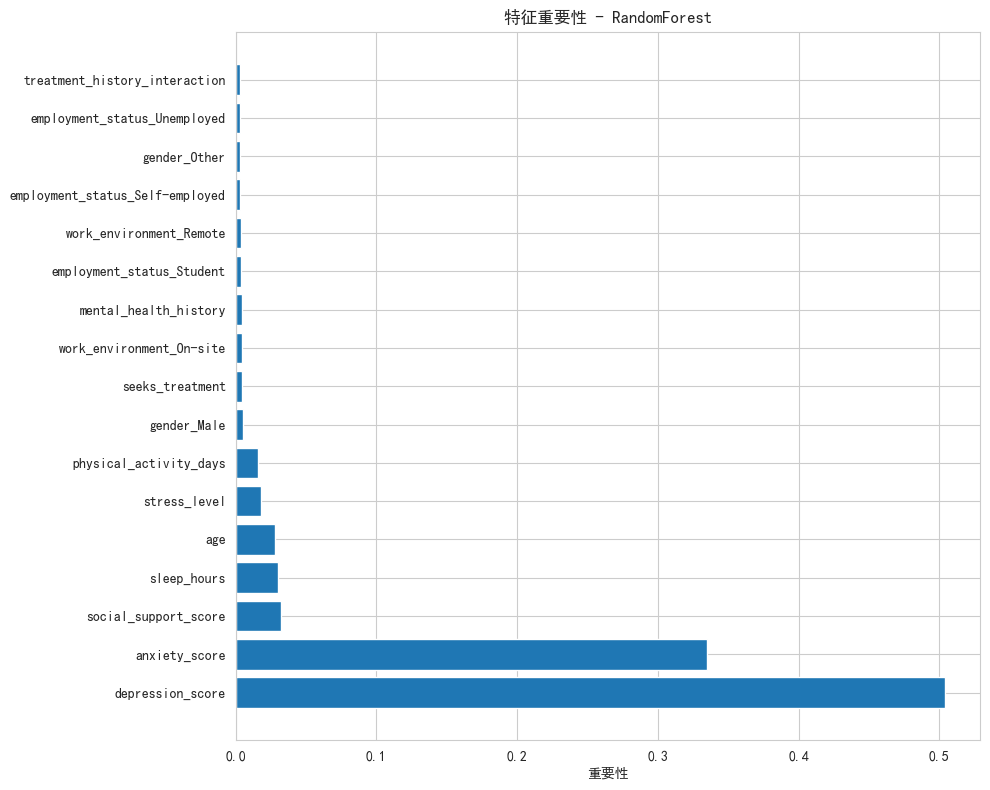


模型已保存为 randomforest_model.pkl

RandomForest 模型总结:
总体 F1 分数: 0.9815
高风险类别识别能力 (召回率): 0.9789


In [33]:
# 选择要运行的模型
selected_model = "RandomForest"  # 可选: "LogisticRegression", "DecisionTree", "RandomForest", "GradientBoosting", "XGBoost", "SVM", "KNN", "NaiveBayes", "NeuralNetwork"

# 运行选定的模型
model_result = run_specific_model(selected_model, X_train, X_test, y_train, y_test, class_names)

# 输出主要结果摘要
print(f"\n{selected_model} 模型总结:")
print(f"总体 F1 分数: {model_result['f1_score']:.4f}")
print(f"高风险类别识别能力 (召回率): {model_result['high_recall']:.4f}")